In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from sam2.build_sam import build_sam2_camera_predictor

import supervision as sv
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from torchvision.ops import masks_to_boxes

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
# Load SAM2 model
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "/media/ssd/bbws_drone/segment-anything-2-real-time/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
# Load OWLv2 model
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [7]:
def query_detection(prompts, image):
    # Preprocess the image
    inputs = processor(text=prompts, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.shape[:2]]).repeat(len(prompts), 1)

    # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
    i = 0  # Retrieve predictions for the first image for the corresponding text queries

    detections = sv.Detections.from_transformers(results[i])

    return detections

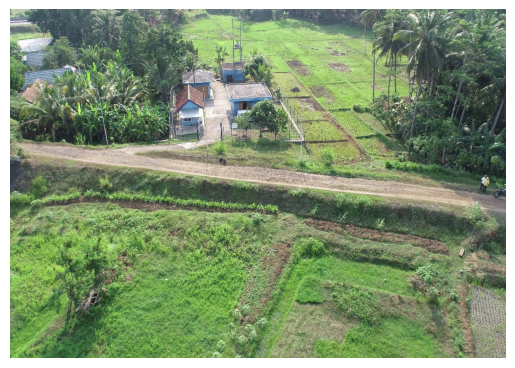

In [18]:
# Load Image
image_path = "/media/ssd/bbws_drone/Grounded-SAM-2/data/DJI_0262_Images"
images_paths = sorted([os.path.join(image_path, img_name) for img_name in os.listdir(image_path)])

# Load the first image
image = Image.open(images_paths[0])
image = np.array(image)

# Show the image
plt.imshow(image)
plt.axis("off")
plt.show()

In [92]:
tracker = sv.ByteTrack(track_activation_threshold=0.10)

In [93]:
# detections = query_detection(prompts, image)
# print(detections)
# detections = tracker.update_with_detections(detections)
# print(detections)

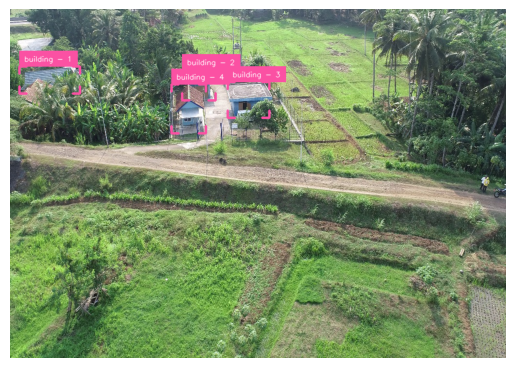

In [94]:
# Predict the bounding boxes using OWL-V2
labels = ["building"]
prompts = [labels]

detections = query_detection(prompts, image)
detections = tracker.update_with_detections(detections)

corner_annotator = sv.BoxCornerAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_frame = corner_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[f"{labels[idx]} - {tracker_id}" for idx, tracker_id in zip(detections.class_id, detections.tracker_id)]
    # labels=[f"{labels[idx]}" for idx in ÷detections.class_id]
    
)

plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [134]:
def detection_from_segmentation(detections, out_obj_ids, out_mask_logits):
    tracker_id_to_obj_id = {detections.tracker_id[i]: i for i in range(len(detections))}

    # Update the mask for each detection
    out_masks = out_mask_logits[:, 0, ...].cpu().numpy() > 0.0
    total_area = np.sum(out_masks, axis=(1, 2))

    # Filter out masks with area less than 10
    out_masks = out_masks[total_area > 10]

    detections.mask = np.zeros((len(detections), image.shape[0], image.shape[1]), dtype=bool)

    segmentation_bbox = masks_to_boxes(torch.tensor(out_masks).float()).numpy()

    for obj_id, object_mask in zip(out_obj_ids, out_masks):
        if obj_id not in tracker_id_to_obj_id:
            continue
        
        detection_idx = tracker_id_to_obj_id[obj_id]
        
        # Update detection with the mask
        detections.mask[detection_idx] = object_mask

        # Update detection with the segmentation bbox
        detections.xyxy[detection_idx] = segmentation_bbox[detection_idx]

    return detections

In [100]:
corner_annotator = sv.BoxCornerAnnotator(color_lookup=sv.ColorLookup.TRACK)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.TRACK)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.TRACK)

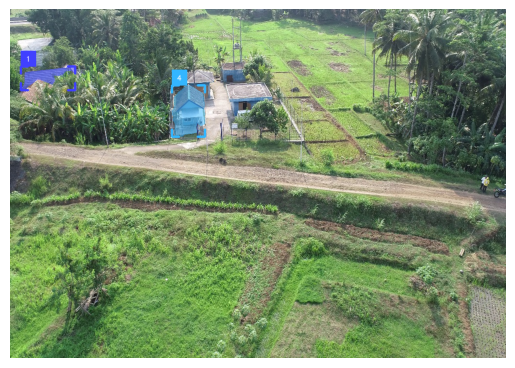

In [106]:
# Add first frame to sam2 predictor
predictor.load_first_frame(image)
ann_frame_idx = 0

for ann_obj_id in range(len(detections)):
    box = detections.xyxy[ann_obj_id]
    bbox = np.array([box[:2], box[2:]])
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=detections.tracker_id[ann_obj_id], bbox=bbox
    )

detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)

annotated_frame = corner_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[f"{tracker_id}" for idx, tracker_id in zip(detections.class_id, detections.tracker_id)]
)

annotated_frame = mask_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

plt.imshow(annotated_frame)
plt.axis("off")
plt.show()





In [127]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1, box2: tuples or lists containing bounding box coordinates in the format (xmin, ymin, xmax, ymax)

    Returns:
    - iou: float, the IoU between box1 and box2
    """
    # Unpack coordinates for both boxes
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Calculate the intersection coordinates
    x_inter_min = max(xmin1, xmin2)
    y_inter_min = max(ymin1, ymin2)
    x_inter_max = min(xmax1, xmax2)
    y_inter_max = min(ymax1, ymax2)

    # Calculate the area of the intersection
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    inter_area = inter_width * inter_height

    # Calculate the area of both bounding boxes
    area_box1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area_box2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calculate the union area
    union_area = area_box1 + area_box2 - inter_area

    # Calculate the IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

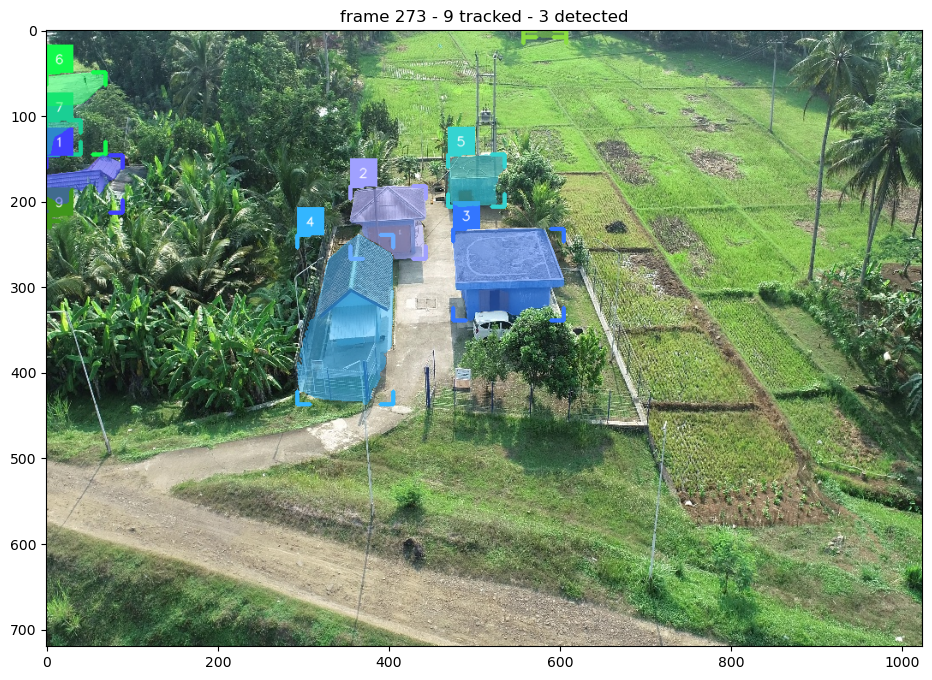

RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [133]:
# Predict the bounding boxes using OWL-V2
labels = ["building"]
prompts = [labels]

redetect_interval = 10
max_id = 0

# tracker = sv.ByteTrack(track_activation_threshold=0.05)
total_new_detected = 0

for frame_idx, image_path in enumerate(images_paths):
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    width, height = frame.shape[:2][::-1]

    if frame_idx == 0:
        predictor.reset_state()
        predictor.load_first_frame(frame)

        detections = query_detection(prompts, frame)
        total_new_detected = len(detections)
        detections.tracker_id = np.arange(0, len(detections)) + max_id + 1

        for ann_obj_id in range(len(detections)):
            box = detections.xyxy[ann_obj_id]
            obj_id = detections.tracker_id[ann_obj_id]
            bbox = np.array([box[:2], box[2:]])
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                frame_idx=0, obj_id=obj_id, bbox=bbox
            )

        detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)
        max_id = detections.tracker_id.max()
        # detections = tracker.update_with_detections(detections)

    elif frame_idx != 0 and frame_idx % redetect_interval == 0:
        new_detections = query_detection(prompts, frame)
        total_new_detected = len(new_detections)

        valid_new_detection_idx = []

        # Add new detections if the IoU is less than 0.5
        for new_det_idx in range(len(new_detections)):
            new_det = new_detections.xyxy[new_det_idx]

            ious = [calculate_iou(new_det, det) for det in detections.xyxy]
            if all(iou < 0.5 for iou in ious):
                valid_new_detection_idx.append(new_det_idx)

        new_detections = new_detections[valid_new_detection_idx]
        new_detections.mask = np.zeros((len(new_detections), image.shape[0], image.shape[1]), dtype=bool)

        if len(new_detections) > 0:
            new_detections.tracker_id = np.arange(0, len(new_detections)) + max_id + 1
            max_id = new_detections.tracker_id.max()
            
            detections = sv.Detections.merge([detections, new_detections])

            predictor.reset_state()
            predictor.load_first_frame(frame)

            for ann_obj_id in range(len(detections)):
                box = detections.xyxy[ann_obj_id]
                obj_id = detections.tracker_id[ann_obj_id]
                bbox = np.array([box[:2], box[2:]])
                _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                    frame_idx=0, obj_id=obj_id, bbox=bbox
                )

            detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)
    
    else:
        out_obj_ids, out_mask_logits = predictor.track(frame)
        detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)


    annotated_frame = corner_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=[f"{tracker_id}" for idx, tracker_id in zip(detections.class_id, detections.tracker_id)]
    )

    annotated_frame = mask_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    display.clear_output(wait=True)
    plt.figure(figsize=(12, 8))
    plt.title(f"frame {frame_idx} - {len(detections)} tracked - {total_new_detected} detected")
    plt.imshow(annotated_frame)

    plt.show()


In [54]:
from torchvision.ops import masks_to_boxes

masks_to_boxes(out_mask_logits[:, 0, ...] > 0.0)

tensor([[ 22., 117., 136., 168.],
        [356., 125., 421., 185.],
        [445., 151., 541., 220.],
        [334., 157., 402., 261.]], device='cuda:0')

In [ ]:
# Add first frame to sam2 predictor
predictor.load_first_frame(image)
ann_frame_idx = 0

